## SInCohMap data access and processing examples
### Author michele.claus@eurac.edu
### Date: 2022/02/15

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

## FAQ:
**Q: I receive a 403 error, what does it mean?**

A: If you get a 403 error, it usually means that the connection with the openEO back-end dropped. Please re run

`conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")`

and re run you code from `load_collection` onwards.

**Q: I receive a 500 error, what does it mean?**

A: It is a server error: something went wrong processing your request. Please check carefully that the area and time range you are requesting are available in the datacube (you can use `conn.describe_collection('COLLECTION_NAME')`) Currently the error logs are not passed if you run your request as a synchronous call (i.e. using `.download()`). If you run you process as a batch job you will get a more informative error message.

**Q: I receive a 502 error, what does it mean?**

A: If you get an error similar to: _[502] unknown: Received 502 Proxy Error. This typically happens if an OpenEO request takes too long and is killed. Consider using batch jobs instead of doing synchronous processing._
The message is already explaining you the problem: you are using a synchronous call (.download()) to run a process which is taking too much to complete. You need to use a batch job in this case.

If you already started a batch job, please try to list the jobs with:
`conn.list_jobs()`
and check if it's actually running of it has been stopped due to an error.

### Import all the libraries and utilities functions included in the eo_utils.py file

In [1]:
from eo_utils import *

### Connect and login

In [2]:
openeoHost = "https://openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


Please check to have the latest openeo library. openeo >= 0.9.0 is required

In [3]:
openeo.__version__

'0.9.2'

## Doñana Datacubes:
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA
SAR2Cube_SInCohMap_S1_L0_154_DSC_DONYANA
```
Sentinel-2:
```
SInCohMap_S2_L1C_T29SQB
```
## South Tyrol Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL
SAR2Cube_SInCohMap_S1_L0_168_DSC_SOUTH_TYROL
```
Sentinel-2:
```
S2_L1C_T32TPS
```
## Finland Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI1
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI2
```

# Coherence


Firstly download a tiny subset of the datacube for the whole timeseries.
With the downloaded netCDF we can extract the available dates and compute the master-slave pairs for the given temporal baseline.

**Please note: this step is not necessary since sample netCDFs with the vailable dates are already provided in the GitHub repo in the aux_data folder.**

The available netCDFs containing the dates for the SInCohMap Sentinel-1 datacubes are:
```
./aux_data/Donyana_ASC_147_dates.nc
./aux_data/Donyana_DSC_154_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/South_Tyrol_DSC_168_dates.nc
./aux_data/South_Tyrol_ASC_117_dates.nc
```

In [ ]:
# conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
# spatial_extent  = {'west':-6.094129 ,'east':-6.091833 ,'south':37.115613 ,'north':37.117239}
# collection      = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'
# # Not specifying the temporal extent will load the whole timeseries
# bands = ['grid_lon','grid_lat']
# S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

In [ ]:
# %%time
# S1_slant_range.download('./aux_data/Donyana_ASC_147_dates.nc')

## Select the AOI
Use the rectangle selection tool to select the area of interest

In [4]:
center = [37.2, -6.2]
zoom = 9

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[37.2, -6.2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [5]:
bbox = eoMap.getBbox()
print("Coordinates selected from map:",'\n west',bbox[0],'\n east',bbox[2],'\n south',bbox[1],'\n north',bbox[3])
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}


Coordinates selected from map: 
 west -6.161957 
 east -5.953217 
 south 36.93694 
 north 37.09265


Compute the master-slave pairs for the given temporal baseline.

Read the retrieved netCDF containing the timestamps:

In [7]:
dates_netcdf = xr.open_dataarray('./aux_data/Donyana_ASC_147_dates.nc')
dates_netcdf.time

<xarray.DataArray 'time' (time: 181)>
array(['2017-01-02T23:59:59.000000000', '2017-01-08T23:59:59.000000000',
       '2017-01-14T23:59:59.000000000', '2017-01-20T23:59:59.000000000',
       '2017-01-26T23:59:59.000000000', '2017-02-01T23:59:59.000000000',
       '2017-02-07T23:59:59.000000000', '2017-02-13T23:59:59.000000000',
       '2017-02-19T23:59:59.000000000', '2017-02-25T23:59:59.000000000',
       '2017-03-03T23:59:59.000000000', '2017-03-09T23:59:59.000000000',
       '2017-03-15T23:59:59.000000000', '2017-03-21T23:59:59.000000000',
       '2017-04-02T23:59:59.000000000', '2017-04-08T23:59:59.000000000',
       '2017-04-14T23:59:59.000000000', '2017-04-20T23:59:59.000000000',
       '2017-04-26T23:59:59.000000000', '2017-05-02T23:59:59.000000000',
       '2017-05-08T23:59:59.000000000', '2017-05-14T23:59:59.000000000',
       '2017-05-20T23:59:59.000000000', '2017-05-26T23:59:59.000000000',
       '2017-06-01T23:59:59.000000000', '2017-06-07T23:59:59.000000000',
       '2017-06-13T23:59:59.000000000', '2017-06-19T23:59:59.000000000',
       '2017-06-25T23:59:59.000000000', '2017-07-01T23:59:59.000000000',
       '2017-07-07T23:59:59.000000000', '2017-07-13T23:59:59.000000000',
       '2017-07-19T23:59:59.000000000', '2017-07-25T23:59:59.000000000',
       '2017-07-31T23:59:59.000000000', '2017-08-06T23:59:59.000000000',
       '2017-08-12T23:59:59.000000000', '2017-08-18T23:59:59.000000000',
       '2017-08-24T23:59:59.000000000', '2017-08-30T23:59:59.000000000',
       '2017-09-05T23:59:59.000000000', '2017-09-11T23:59:59.000000000',
       '2017-09-17T23:59:59.000000000', '2017-09-23T23:59:59.000000000',
       '2017-09-29T23:59:59.000000000', '2017-10-05T23:59:59.000000000',
       '2017-10-11T23:59:59.000000000', '2017-10-17T23:59:59.000000000',
       '2017-10-23T23:59:59.000000000', '2017-10-29T23:59:59.000000000',
       '2017-11-04T23:59:59.000000000', '2017-11-10T23:59:59.000000000',
       '2017-11-16T23:59:59.000000000', '2017-11-22T23:59:59.000000000',
       '2017-11-28T23:59:59.000000000', '2017-12-04T23:59:59.000000000',
       '2017-12-10T23:59:59.000000000', '2017-12-16T23:59:59.000000000',
       '2017-12-22T23:59:59.000000000', '2017-12-28T23:59:59.000000000',
       '2018-01-03T23:59:59.000000000', '2018-01-09T23:59:59.000000000',
       '2018-01-15T23:59:59.000000000', '2018-01-21T23:59:59.000000000',
       '2018-01-27T23:59:59.000000000', '2018-02-02T23:59:59.000000000',
       '2018-02-08T23:59:59.000000000', '2018-02-14T23:59:59.000000000',
       '2018-02-20T23:59:59.000000000', '2018-02-26T23:59:59.000000000',
       '2018-03-04T23:59:59.000000000', '2018-03-10T23:59:59.000000000',
       '2018-03-16T23:59:59.000000000', '2018-03-22T23:59:59.000000000',
       '2018-03-28T23:59:59.000000000', '2018-04-03T23:59:59.000000000',
       '2018-04-09T23:59:59.000000000', '2018-04-15T23:59:59.000000000',
       '2018-04-21T23:59:59.000000000', '2018-04-27T23:59:59.000000000',
       '2018-05-03T23:59:59.000000000', '2018-05-09T23:59:59.000000000',
       '2018-05-15T23:59:59.000000000', '2018-05-21T23:59:59.000000000',
       '2018-05-27T23:59:59.000000000', '2018-06-02T23:59:59.000000000',
       '2018-06-08T23:59:59.000000000', '2018-06-14T23:59:59.000000000',
       '2018-06-26T23:59:59.000000000', '2018-07-02T23:59:59.000000000',
       '2018-07-08T23:59:59.000000000', '2018-07-14T23:59:59.000000000',
       '2018-07-20T23:59:59.000000000', '2018-07-26T23:59:59.000000000',
       '2018-08-01T23:59:59.000000000', '2018-08-07T23:59:59.000000000',
       '2018-08-13T23:59:59.000000000', '2018-08-19T23:59:59.000000000',
       '2018-08-25T23:59:59.000000000', '2018-08-31T23:59:59.000000000',
       '2018-09-06T23:59:59.000000000', '2018-09-12T23:59:59.000000000',
       '2018-09-18T23:59:59.000000000', '2018-09-24T23:59:59.000000000',
       '2018-09-30T23:59:59.000000000', '2018-10-06T23:59:59.000000000',
       '2018-10-12T23:59:59.000000000', '2018-10-18T23:59:59.000000000',
       '2018-10-24T2

Coherence temporal baseline

In [8]:
timedelta = 6

We want to compute the coherence over the year 2018 and therefore we keep the 2018 dates. (Please try a small temporal extent firstly)

In [12]:
timesteps = dates_netcdf['time'].loc[dict(time=slice('2018-01-01','2018-01-15'))].values
print("First date available for 2018: ",timesteps[0])
print("Last date available for 2018:  ",timesteps[-1])

First date available for 2018:  2018-01-03T23:59:59.000000000
Last date available for 2018:   2018-01-15T23:59:59.000000000


We loop through the timesteps and check where we have 6 or 12 or ... days pairs of dates

In [13]:
dates_pair = []
for i,t in enumerate(timesteps[:-1]):
    for t2 in timesteps[i+1:]:
        if(np.timedelta64(t2 - t, 'D')) == np.timedelta64(timedelta,'D'):
            dates_pair.append([t,t2])
print("First date pair: ",dates_pair[0])
print("Last date pair:  ",dates_pair[-1])

First date pair:  [numpy.datetime64('2018-01-03T23:59:59.000000000'), numpy.datetime64('2018-01-09T23:59:59.000000000')]
Last date pair:   [numpy.datetime64('2018-01-09T23:59:59.000000000'), numpy.datetime64('2018-01-15T23:59:59.000000000')]


We define new temporal labels containing the master and slave dates:

In [14]:
mst_slv_temporal_labels = [ str(i[0])[:10] + "_" + str(i[1])[:10] for i in dates_pair]
mst_slv_temporal_labels.reverse()
print("The output will have a temporal label named like this: ",mst_slv_temporal_labels[0])

The output will have a temporal label named like this:  2018-01-03_2018-01-09


We now got the master-slave date pairs which will be used to compute the coherence.

Now we define the utility functions for computing the complex coherence and then its amplitude

In [15]:
def compute_real_part_numerator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VV_mst')
    q_mst = array_element(x,label='q_VV_mst')
    i_slv = array_element(x,label='i_VV_slv')
    q_slv = array_element(x,label='q_VV_slv')
    return (i_mst*i_slv + q_mst*q_slv)

def compute_imag_part_numerator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VV_mst')
    q_mst = array_element(x,label='q_VV_mst')
    i_slv = array_element(x,label='i_VV_slv')
    q_slv = array_element(x,label='q_VV_slv')
    return (q_mst*i_slv - i_mst*q_slv)

def compute_real_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VH_mst')
    q_mst = array_element(x,label='q_VH_mst')
    i_slv = array_element(x,label='i_VH_slv')
    q_slv = array_element(x,label='q_VH_slv')
    return (i_mst*i_slv + q_mst*q_slv)

def compute_imag_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VH_mst')
    q_mst = array_element(x,label='q_VH_mst')
    i_slv = array_element(x,label='i_VH_slv')
    q_slv = array_element(x,label='q_VH_slv')
    return (q_mst*i_slv - i_mst*q_slv)

def compute_mst_denominator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VV_mst')
    q_mst = array_element(x,label='q_VV_mst')
    return (i_mst**2+q_mst**2)

def compute_slv_denominator_VV(x:ProcessBuilder):
    i_slv = array_element(x,label='i_VV_slv')
    q_slv = array_element(x,label='q_VV_slv')
    return (i_slv**2+q_slv**2)

def compute_mst_denominator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VH_mst')
    q_mst = array_element(x,label='q_VH_mst')
    return (i_mst**2+q_mst**2)

def compute_slv_denominator_VH(x:ProcessBuilder):
    i_slv = array_element(x,label='i_VH_slv')
    q_slv = array_element(x,label='q_VH_slv')
    return (i_slv**2+q_slv**2)

def compute_coherence_amplitude_VV(x:ProcessBuilder):
    q_num_VV = array_element(x,label='q_num_VV')
    i_num_VV = array_element(x,label='i_num_VV')
    mst_den = array_element(x,label='mst_den')
    slv_den = array_element(x,label='slv_den')
    
    coh_i = i_num_VV / ((mst_den * slv_den + 1e-12)**0.5)
    coh_q = q_num_VV / ((mst_den * slv_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

def compute_coherence_amplitude_VH(x:ProcessBuilder):
    q_num_VH = array_element(x,label='q_num_VH')
    i_num_VH = array_element(x,label='i_num_VH')
    mst_den = array_element(x,label='mst_den')
    slv_den = array_element(x,label='slv_den')
    
    coh_i = i_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    coh_q = q_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

Coherence parameters:

In [62]:
# Multi-look filter
range_looks   = 19
azimuth_looks = 4

# Geocoding
resolution = 20 # can be 10, 20 or 60 meters, it will be aligned with the Sentinel-2 grid
crs = 32630

# Spatial extent from AOI selected in the map
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}

# Datacube
collection      = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'

In [63]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
bands = ['grid_lon','grid_lat','i_VV','q_VV','i_VH','q_VH']
S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

# We use a loop over the dates we want to request and a combination of filter_temporal + merge_cubes to get only the dates we want:
for i,date_pair in enumerate(dates_pair):
    # The requested date until the day after, since openEO excludes the end date
    mst_date = date_pair[0]
    slv_date = date_pair[1]
    mst_temporal_extent = [str(mst_date),str(mst_date + np.timedelta64(1, 'D'))]
    slv_temporal_extent = [str(slv_date),str(slv_date + np.timedelta64(1, 'D'))]

    if i == 0:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent)
    else:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent).merge_cubes(S1_slant_range_mst_bands)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent).merge_cubes(S1_slant_range_slv_bands)

Authenticated using refresh token.


In [64]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.filter_bands(['i_VV','q_VV','i_VH','q_VH'])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.filter_bands(['i_VV','q_VV','i_VH','q_VH'])

We rename the temporal labels to facilitate the next steps of the coherence computation:

In [65]:
# We need to call rename_labels in this way because calling it directly as we do for the bands returns an error for the temporal dimension
args_rename_labels = {'data': THIS,'dimension':'DATE','target':mst_slv_temporal_labels}

S1_slant_range_mst_bands = S1_slant_range_mst_bands.process('rename_labels',args_rename_labels)
S1_slant_range_slv_bands = S1_slant_range_slv_bands.process('rename_labels',args_rename_labels)

We rename the bands according to the master/slave members

In [66]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.rename_labels(dimension='bands',source=['i_VV','q_VV','i_VH','q_VH'],target=['i_VV_mst','q_VV_mst','i_VH_mst','q_VH_mst'])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.rename_labels(dimension='bands',source=['i_VV','q_VV','i_VH','q_VH'],target=['i_VV_slv','q_VV_slv','i_VH_slv','q_VH_slv'])

Merge the two datacubes into a single one

In [67]:
S1_slant_range_mst_slv_bands = S1_slant_range_mst_bands.merge_cubes(S1_slant_range_slv_bands)

Compute the coherence numerator for VV and VH

In [68]:
i_numerator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_real_part_numerator_VV)
q_numerator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_imag_part_numerator_VV)

i_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_real_part_numerator_VH)
q_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_imag_part_numerator_VH)

Apply multilook to real and imaginary part of the numerator

In [70]:
i_numerator_VV_ML = i_numerator_VV.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=i_numerator_VV._get_callback(mean,parent_parameters=['data']))
q_numerator_VV_ML = q_numerator_VV.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=q_numerator_VV._get_callback(mean,parent_parameters=['data']))

i_numerator_VH_ML = i_numerator_VH.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=i_numerator_VH._get_callback(mean,parent_parameters=['data']))
q_numerator_VH_ML = q_numerator_VH.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=q_numerator_VH._get_callback(mean,parent_parameters=['data']))

Compute the coherence denominator for VV and VH

In [71]:
mst_denominator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_mst_denominator_VV)
slv_denominator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_slv_denominator_VV)

mst_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_mst_denominator_VH)
slv_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',reducer=compute_slv_denominator_VH)

Apply multilook to the denominator

In [72]:
mst_denominator_VV_ML = mst_denominator_VV.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=mst_denominator_VV._get_callback(mean,parent_parameters=['data']))
slv_denominator_VV_ML = slv_denominator_VV.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=slv_denominator_VV._get_callback(mean,parent_parameters=['data']))

mst_denominator_VH_ML = mst_denominator_VH.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=mst_denominator_VH._get_callback(mean,parent_parameters=['data']))
slv_denominator_VH_ML = slv_denominator_VH.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=slv_denominator_VH._get_callback(mean,parent_parameters=['data']))

Merge all the bands for VV

In [73]:
i_numerator_VV_ML = i_numerator_VV_ML.add_dimension(name='bands',label='i_num_VV')
q_numerator_VV_ML = q_numerator_VV_ML.add_dimension(name='bands',label='q_num_VV')

mst_denominator_VV_ML = mst_denominator_VV_ML.add_dimension(name='bands',label='mst_den')
slv_denominator_VV_ML = slv_denominator_VV_ML.add_dimension(name='bands',label='slv_den')

coh_numerator_denominator_VV = i_numerator_VV_ML.merge_cubes(q_numerator_VV_ML).merge_cubes(mst_denominator_VV_ML).merge_cubes(slv_denominator_VV_ML)

Merge all the bands for VH

In [74]:
i_numerator_VH_ML = i_numerator_VH_ML.add_dimension(name='bands',label='i_num_VH')
q_numerator_VH_ML = q_numerator_VH_ML.add_dimension(name='bands',label='q_num_VH')

mst_denominator_VH_ML = mst_denominator_VH_ML.add_dimension(name='bands',label='mst_den')
slv_denominator_VH_ML = slv_denominator_VH_ML.add_dimension(name='bands',label='slv_den')

coh_numerator_denominator_VH = i_numerator_VH_ML.merge_cubes(q_numerator_VH_ML).merge_cubes(mst_denominator_VH_ML).merge_cubes(slv_denominator_VH_ML)

Compute the coherence amplitude

In [75]:
coh_VV = coh_numerator_denominator_VV.reduce_dimension(dimension='bands',reducer=compute_coherence_amplitude_VV)
coh_VV = coh_VV.add_dimension(name='bands',label='coh_vv_amp')

coh_VH = coh_numerator_denominator_VH.reduce_dimension(dimension='bands',reducer=compute_coherence_amplitude_VH)
coh_VH = coh_VH.add_dimension(name='bands',label='coh_vh_amp')

Merge VV and VH

In [76]:
coh_amplitude = coh_VH.merge_cubes(coh_VV)

Geocoding

In [77]:
lat_lon_grids = S1_slant_range.filter_bands(['grid_lon','grid_lat']).reduce_dimension(dimension='DATE',reducer=mean)
lat_lon_grids = lat_lon_grids.process('aggregate_spatial_window',data=THIS,boundary='trim',size=[range_looks,azimuth_looks],reducer=lat_lon_grids._get_callback(mean,parent_parameters=['data']))

coh_amplitude = coh_amplitude.merge_cubes(lat_lon_grids)

args_geocoding = {'resolution':resolution,'crs':crs}
coh_amplitude_geocoded = coh_amplitude.process("geocode",args_geocoding, data=coh_amplitude)

coh_amplitude_geocoded_nc = coh_amplitude_geocoded.save_result(format='netCDF')

In [78]:
job = conn.create_job(coh_amplitude_geocoded_nc,title="DONYANA_ASC_coherence_ML")
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    job.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  a3db015d-55e7-4a79-a5c3-2260322a541e


In [80]:
conn.list_jobs()

[{'id': '438e2da5-9fdb-4396-abf0-62f03118efd0',
  'ownerPrincipal': 'michele.claus@eurac.edu',
  'title': 'SAR2Cube_coherence_VV_VH',
  'description': None,
  'process': {'process_graph': {'23': {'process_id': 'rename_labels',
     'arguments': {'data': {'from_node': 'coh_imag_VH'},
      'source': [],
      'dimension': 'bands',
      'target': ['COH_q_VH']}},
    '24': {'process_id': 'merge_cubes',
     'arguments': {'cube2': {'from_node': '23'},
      'cube1': {'from_node': '20'}}},
    '27': {'result': True,
     'process_id': 'save_result',
     'arguments': {'data': {'from_node': '32'}, 'format': 'GTiff'}},
    '28': {'process_id': 'filter_temporal',
     'arguments': {'extent': ['2018-01-06T00:00:00Z', '2018-01-08T23:59:59Z'],
      'data': {'from_node': '1'}}},
    '29': {'process_id': 'filter_temporal',
     'arguments': {'extent': ['2018-01-12T00:00:00Z', '2018-01-14T23:59:59Z'],
      'data': {'from_node': '1'}}},
    'INTENSITY': {'process_id': 'reduce_dimension',
     'arguments': {'data': {'from_node': '30'},
      'context': '',
      'reducer': {'process_graph': {'9ueocha1t': {'process_id': 'power',
         'arguments': {'p': 2, 'base': {'from_node': 'ig51rtyk7'}}},
        'z1tq33ah0': {'process_id': 'add',
         'arguments': {'x': {'from_node': '9ueocha1t'},
          'y': {'from_node': 'll3ls24ps'}}},
        'd5616wu8k': {'process_id': 'array_element',
         'arguments': {'data': {'from_parameter': 'data'},
          'label': 'COH_q_VH'}},
        'ig51rtyk7': {'process_id': 'array_element',
         'arguments': {'data': {'from_parameter': 'data'},
          'label': 'COH_i_VH'}},
        'z3nxzpnt0': {'result': True,
         'process_id': 'power',
         'arguments': {'p': 0.5, 'base': {'from_node': 'z1tq33ah0'}}},
        'll3ls24ps': {'process_id': 'power',
         'arguments': {'p': 2, 'base': {'from_node': 'd5616wu8k'}}}}},
      'dimension': 'bands'}},
    'coh_imag_VV': {'process_id': 'reduce_dimension',
     'arguments': {'data': {'from_node': '19'},
      'context': '',
      'reducer': {'process_graph': {'9hzgoy0zv': {'process_id': 'array_element',
         'arguments': {'data': {'from_parameter': 'data'}, 'label': 'VV_i_0'}},
        'cbyq53c6c': {'process_id': 'sqrt',
         'arguments': {'x': {'from_node': 'xcpvz9epu'}}},
        'iiivdkt5x': {'process_id': 'power',
         'arguments': {'p': 2, 'base': {'from_node': '9hzgoy0zv'}}},
        '63d5swqus': {'process_id': 'power',
         'arguments': {'p': 2, 'base': {'from_node': '0hj07zkit'}}},
        'u8eq67uxb': {'process_id': 'multiply',
         'arguments': {'x': {'from_node': '0hj07zkit'},
          'y': {'from_node': 'ui1pbzemv'}}},
        'xcpvz9epu': {'process_id': 'multiply',
         'arguments': {'x': {'from_node': '5pu09eb8e'},
          'y': {'from_node': 'jb6qd2h9k'}}},
        'zi33vbeuo': {'process_id': 'array_element',
         'arguments': {'data': {'from_parameter': 'data'}, 'label': 'VV_i_1'}},
        'qfksu50g5': {'process_id': 'multiply',
         'arguments': {'x': {'from_node': '9hzgoy0zv'},
          'y': {'from_node': 'zi33vbeuo'}}},
        '5pu09eb8e': {'process_id': 'add',
         'arguments': {'x': {'from_node': 'iiivdkt5x'},
          'y': {'from_node': '63d5swqus'}}},
        'tnps8jufq': {'result': True,
         'process_id': 'divide',
         'arguments': {'x': {'from_node': 'jeq2b2s1r'},
          'y': {'from_node': 'cbyq53c6c'}}},
        'ui1pbzemv': {'process_id': 'array_element',
         'arguments': {'data': {'from_parameter': 'data'}, 'label': 'VV_q_1'}},
        'jeq2b2s1r': {'process_id': 'add',
         'arguments': {'x': {'from_node': 'qfksu50g5'},
          'y': {'from_node': 'u8eq67uxb'}}},
        '8pnot4zwn': {'process_id': 'power',
         'arguments': {'p': 2, 'base': {'from_node': 'zi33vbeuo'}}},
        '0hj07zkit': {'process_id': 'array_element',
         'arguments': {'data': {'from_parameter': 'data'}, 'label': 'VV_q_0'}},
        '5csoq19ox': {'process_id': 'power'

Download all the results if all the jobs have been completed

In [81]:
import os
result_dir_name = "coherence_results_ML"
os.mkdir(result_dir_name)

In [82]:
job = conn.job(job_id)

In [83]:
job

<RESTJob job_id='a3db015d-55e7-4a79-a5c3-2260322a541e'>

Once the job is marked as finished, you can download the result.

Either via the download link provided in the following visualization:

In [38]:
result = job.get_results()
result

<JobResults for job 'db69af58-4040-45ca-9302-f206813062c1'>

Or via python code specifying the target location:

In [39]:
result.download_files(result_dir_name + "/")

[PosixPath('coherence_results/result.nc'),
 PosixPath('coherence_results/process.json')]

In [41]:
result = xr.open_dataarray(result_dir_name + "/result.nc")
result

<xarray.DataArray 'stack-eacc49c9382ab7da3794d5c0858d68ab' (variable: 2, time: 2, y: 896, x: 959)>
[3437056 values with dtype=float64]
Coordinates:
  * y            (y) float32 4.092e+06 4.092e+06 4.092e+06 ... 4.11e+06 4.11e+06
  * x            (x) float32 2.184e+05 2.184e+05 ... 2.375e+05 2.376e+05
  * time         (time) object '2018-01-03_2018-01-09' '2018-01-09_2018-01-15'
  * variable     (variable) object 'coh_vh_amp' 'coh_vv_amp'
    spatial_ref  int64 ...
Attributes:
    grid_mapping:  spatial_ref

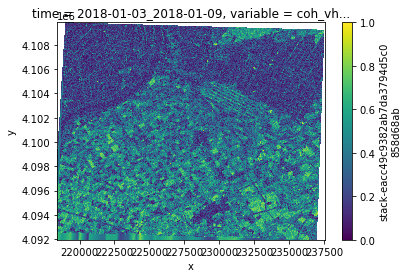

In [53]:
result.loc[dict(variable='coh_vh_amp')][0].plot.imshow(vmin=0,vmax=1)

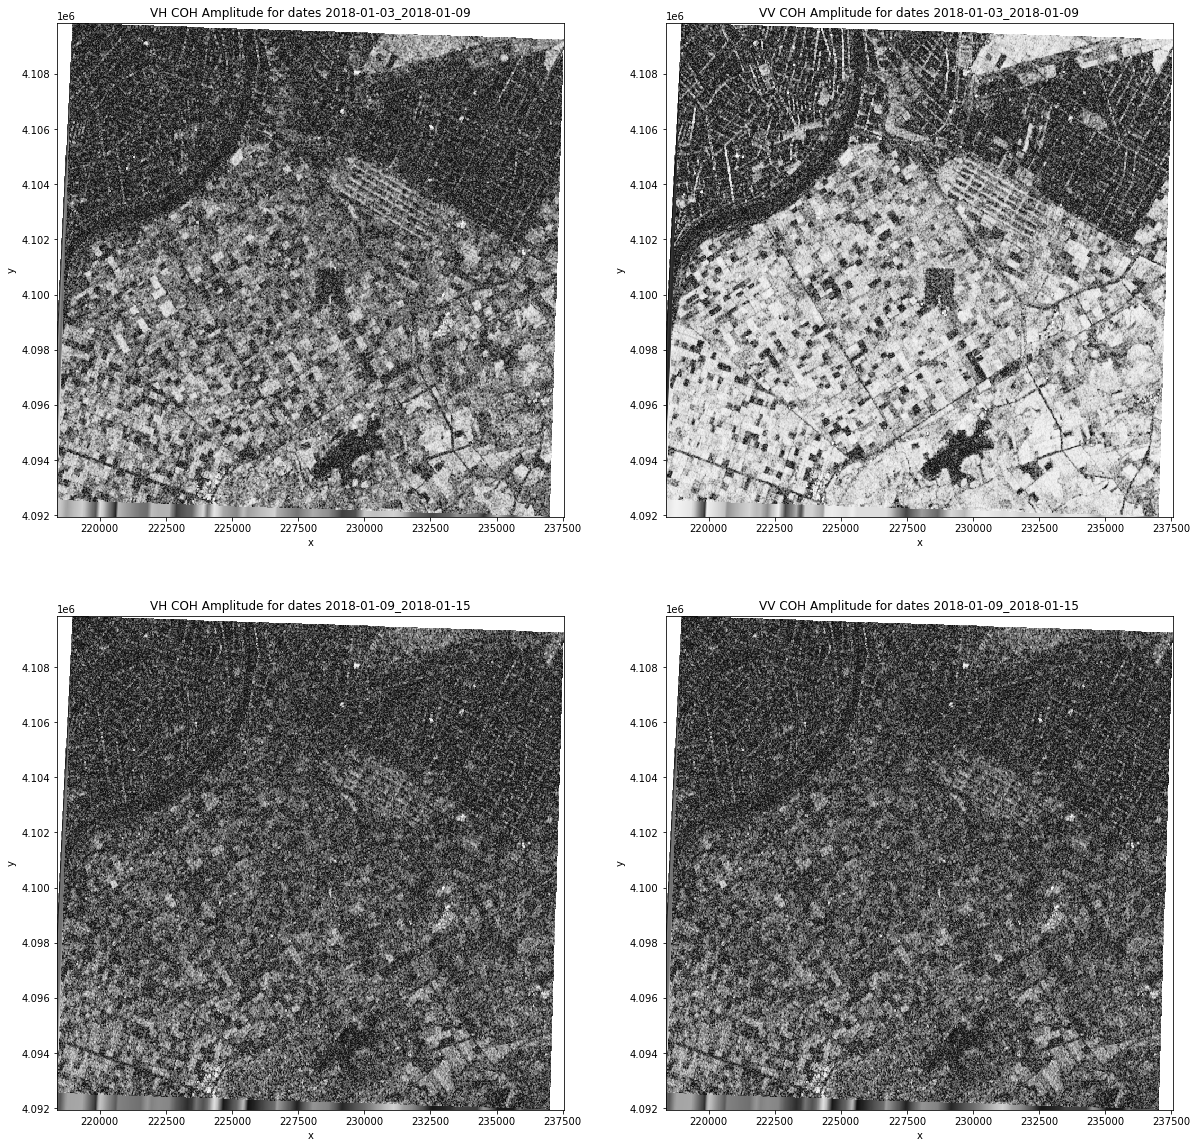

In [61]:
plot_args = {'cmap':'Greys_r','add_colorbar':False}
fig, ax = plt.subplots(2,2,figsize=(20,20))
result.loc[dict(variable='coh_vh_amp')][0].plot.imshow(ax=ax[0,0],**plot_args, vmin=0,vmax=1)
ax[0,0].set_title("VH COH Amplitude for dates " + str(result.loc[dict(variable='coh_vh_amp')]['time'][0].values))
result.loc[dict(variable='coh_vv_amp')][0].plot.imshow(ax=ax[0,1],**plot_args, vmin=0,vmax=1)
ax[0,1].set_title("VV COH Amplitude for dates " + str(result.loc[dict(variable='coh_vv_amp')]['time'][0].values))
result.loc[dict(variable='coh_vh_amp')][1].plot.imshow(ax=ax[1,0],**plot_args, vmin=0,vmax=1)
ax[1,0].set_title("VH COH Amplitude for dates " + str(result.loc[dict(variable='coh_vh_amp')]['time'][1].values))
result.loc[dict(variable='coh_vh_amp')][1].plot.imshow(ax=ax[1,1],**plot_args, vmin=0,vmax=1)
ax[1,1].set_title("VV COH Amplitude for dates " + str(result.loc[dict(variable='coh_vv_amp')]['time'][1].values))
plt.show()

